# 3 Level Flying Cap Converter

<a href="https://colab.research.google.com/github/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/temp_sense_genCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
AC3E Microelectronics Team, November 2022
SPDX-License-Identifier: Apache-2.0
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
| Jorge Marín <br /> Email ID: jorge.marinn@usm.cl|AC3E (Chile)| No |No|
| Christian Rojas |AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Joel |Universidad Católica de Uruguay (Uruguay)| No |No|
| |Universidad Católica de Uruguay (Uruguay)| No |No|
| Alfonso cortés |AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Kevin Pizarro |Universidad Técnica Federico Santa María (Chile)| No |No|
| Vicente Osorio |Universidad Técnica Federico Santa María (Chile)| No |No|
| Tomás Velásquez|Universidad Técnica Federico Santa María (Chile)| No |No|
| Max Vega |Universidad Técnica Federico Santa María (Chile)| No |No|
| Julio Contreras |Universidad Técnica Federico Santa María (Chile)| No |No|
| Diego Almonacid |Universidad Técnica Federico Santa María (Chile)| No |No|
| Carolina Beckman|Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Pablo Vera |Universidad Técnica Federico Santa María (Chile)| No |No|


## Intro

Welcome!
This notebook[^1] serves as an introduction to the temperature sensor generator: an open-source silicon generator parts of [OpenFASoC](https://github.com/idea-fasoc/OpenFASOC) - An open-source framework for autonomous generation of tapeout-ready temperature sensors. This framework uses a leakage-based digital temperature sensor design as the template. A cell-based design methodology is employed to allow full synthesizability and compatibility with computer-aided designs (CADs) flow and advanced technology nodes. Furthermore, the generator automates the design flow end-to-end in Python and supports designing completely with open-source CAD tools.

**_Index Terms:_** Circuit generator, leakage-based temperature dependency, open source, synthesizable design, temperature sensor.

Citation: Q. Zhang et al., "An Open-Source and Autonomous Temperature Sensor Generator Verified With 64 Instances in SkyWater 130 nm for Comprehensive Design Space Exploration," in IEEE Solid-State Circuits Letters, vol. 5, pp. 174-177, 2022, doi: 10.1109/LSSC.2022.3188925.


[^1]: This notebook is targeted at users of all professional backgrounds aiming to learn how to *code* their chips. The goal is to go through all the steps of generating the temperature sensor and an overview of the simulation results. 

## Install all tools and dependencies

## Simulation

### Ron

### Efficiency

 Generator Flow
The temperature sensor applies the below described process to translate a specification into a circuit GDS. 

Before beginning, we must set up our python environment with the necessary open-source tools. The generator uses a flexible set of tools and will support even more in the future. In the below flow walkthrough, we will use:
*   Yosys for logic synthesis
*   Openroad for placing and routing
*   Klayout to produce the final GDS file
*   Magic for DRC and LVS checks as well as PEX
*   Ngspice for simulation

There may be a restart runtime warning after this code block, but disregard.


In [ ]:
# install all tools and dependencies
import os
import pathlib
import sys

!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        netgen \
                        openroad \
                        yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils ngspice
#!bin/micromamba install --yes --prefix $CONDA_PREFIX \
#                        --channel conda-forge \
#                        klayout

!wget https://www.klayout.org/downloads/Ubuntu-18/klayout_0.27.11-1_amd64.deb
!dpkg -i klayout_0.27.11-1_amd64.deb

# clone OpenFASOC repo
!git clone https://github.com/idea-fasoc/OpenFASOC
# setup env
OPENFASOC_ROOT=str(pathlib.Path('OpenFASOC').resolve())
TEMP_SENSE_ROOT=OPENFASOC_ROOT+"/openfasoc/generators/temp-sense-gen/"
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env OPENFASOC_ROOT={OPENFASOC_ROOT}
%env PATH={PATH}:{OPENFASOC_ROOT}:{OPENFASOC_ROOT}/openfasoc/generators/temp-sense-gen/tools
# pip3 packages
!apt install python3-pip
!pip3 install matplotlib pandas pyinstaller ipykernel

### Understanding User Input
The generator must first parse the user’s requirements into a high-level circuit description or verilog. Note that verilog is a circuit description type that uses theoretical constructs (like mathematical operators, if-else blocks, always @ blocks,... etc) to concisely describe circuits. User input parsing is implemented by reading from a JSON spec file directly in the temp-sense-gen repository. The JSON allows for specifying power, area, maximum error (temperature result accuracy), an optimization option (to choose which option to prioritize), and an operating temperature range (minimum and maximum operating temperature values). The operating temperature range and optimization must be specified, but other items can be left blank. The example we are using here runs the sky130 node, and we already have a silicon model file for this node. The generator uses this model file to automatically determine the number of headers and inverters, among other necessary modifications that can be made to meet spec. The generator references the model file in an iterative process until either meeting spec or failing. A verilog description is then produced by substituting specifics into several template verilog files.

You can see this solve and verilog generation by running the code below and exploring the temp-sense-gen/src folder in your python virtual environment:


In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen && make sky130hd_temp_verilog

### Logic Synthesis
At this phase, the implementation of fundamental components — such as transistors and resistors — is not considered. Logic synthesis takes the verilog description from the previous step and outputs a more detailed netlist by parsing theoretical verilog constructs like always, case, if-else, operator, etc… blocks. Note that a netlist is just a list of pins and component connections. Additionally the entire description is consolidated into one file (not considering the node specific library files we will need later) which means that the low and high voltage components are correctly connected. Specifics such as the shapes, placement, length, size of wires and components, along with power connections are still not considered. 

You can see the synthesis step by running the code below and viewing the temp-sense-gen/flow/results/sky130hd/tempsense/1_synth.v file in your python virtual environment:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make synth

### Automatic Place and Route
Now that we have a description of our circuit which includes specific connections and components to use, it is possible to consider drawing the wires, placing the components, and choosing materials. Below is a step-by-step visual breakdown of the openroad APR.

#### Floorplan
First, an outline of the circuit is created encompassing the area that the circuit will occupy and including all the input and output pins for the top level circuit. Inside the temperature sensor, power rails, tap, and decap cells are placed. The tap and decap cells serve to address manufacturing and real-world circuit performance concerns. Within the box, a grid is formed with rows of fixed height.

Run floorplan and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make floorplan

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/2_floorplan.odb OpenFASOC/docs/source/notebooks/aux_files
os.environ['from_oprd_'] = '2_floorplan.odb'
os.environ['to_oprd_'] = 'out2.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/aux_files && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/aux_files && klayout -zz -rd design_name=tempsenseInst_error \
	        -rd in_def="out2.def" \
	        -rd in_gds="HEADER.gds SLC.gds sky130_fd_sc_hd.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out2.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/aux_files/out2.gds /content
flrpln = gdstk.read_gds("out2.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out2.svg')
fig = sg.fromfile('out2.svg')
fig.set_size(('700','700'))
fig.save('out2.svg')
IPython.display.SVG('out2.svg')

####Place
Within the rows (visualized in the run above) the standard cells are placed. Cells are building block circuits that, when combined, implement the bulk of temperature sensor functionality. These standard components include: inverters or other logic gates, headers (used to convert from high to low voltage), SLC (used to convert from low to high voltage), etc. 

Run place and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make place

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/3_place.odb OpenFASOC/docs/source/notebooks/aux_files
os.environ['from_oprd_'] = '3_place.odb'
os.environ['to_oprd_'] = 'out3.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/aux_files && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/aux_files && klayout -zz -rd design_name=tempsenseInst_error \
	        -rd in_def="out3.def" \
	        -rd in_gds="HEADER.gds SLC.gds sky130_fd_sc_hd.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out3.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/aux_files/out3.gds /content
flrpln = gdstk.read_gds("out3.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out3.svg')
fig = sg.fromfile('out3.svg')
fig.set_size(('700','700'))
fig.save('out3.svg')
IPython.display.SVG('out3.svg')

#### CTS
CTS stands for clock tree synthesis (balancing a clock delay to all parts of a circuit); We do not require this in the temperature sensor, but we do require the filler cells which are placed by openroad during CTS. Filler cells are exactly what they sound like. There are many large gaps (see the above run graphic) within each row, between components. These gaps must be filled such that there are continous silicon p and n wells — among other manufacturing and performance reasons. Fillers are placed to fill the gaps.

Run CTS and render a polygon graphic for this stage by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make cts

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
# work dir setup
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/4_cts.odb OpenFASOC/docs/source/notebooks/aux_files
os.environ['from_oprd_'] = '4_cts.odb'
os.environ['to_oprd_'] = 'out4.def'
# convert odb to def
!cd OpenFASOC/docs/source/notebooks/aux_files && openroad -no_init -exit dbtodef.tcl
# convert def to gds
!cd OpenFASOC/docs/source/notebooks/aux_files && klayout -zz -rd design_name=tempsenseInst_error \
	        -rd in_def="out4.def" \
	        -rd in_gds="HEADER.gds SLC.gds sky130_fd_sc_hd.gds" \
	        -rd config_file="fill.json" \
	        -rd out_gds="out4.gds" \
	        -rd tech_file="klayout.lyt" \
	        -rm def2gds.py
!cp OpenFASOC/docs/source/notebooks/aux_files/out4.gds /content
flrpln = gdstk.read_gds("out4.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('out4.svg')
fig = sg.fromfile('out4.svg')
fig.set_size(('700','700'))
fig.save('out4.svg')
IPython.display.SVG('out4.svg')

####Routing
The last step is to connect the components. During routing, wire-like pathways known as traces are placed in the design.

Run route and finish then render a polygon graphic by executing the code below:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make finish

In [ ]:
import gdstk
import IPython.display
import svgutils.transform as sg
!cp OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/6_final.gds /content
flrpln = gdstk.read_gds("6_final.gds".format(TEMP_SENSE_ROOT))
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('6_final.svg')
fig = sg.fromfile('6_final.svg')
fig.set_size(('700','700'))
fig.save('6_final.svg')
IPython.display.SVG('6_final.svg')

### DRC and LVS
Now that the generator has completed the flow, an automatic checking process is initiated. DRC or design rule checking ensures that the final circuit obeys manufacturing rules. Rules are set by the foundry for each of their nodes. LVS or layout vs schematic will compare the final output from APR to the netlist that we gave the APR tool (in this case openroad). This ensures that APR ran correctly and our final circuit matches our netlist description from logic synthesis. Both of these steps will use magic (LVS will also run on magic).

Run checks by executing the below code. Both checks will give command line output below with complete status:

In [ ]:
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make magic_drc
!cd OpenFASOC/openfasoc/generators/temp-sense-gen/flow && make netgen_lvs

 Simulations
To see how the final design functions, run simulations across a temperature range by executing the code block below.

**_Note:_** This may take over 30 minutes.

In [ ]:
%cd /content/OpenFASOC/openfasoc/generators/temp-sense-gen
!mkdir -p work
%cd tools
from simulation import generate_runs
import shutil
import json
import os
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/6_final.gds",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error.gds",
)
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/results/sky130hd/tempsense/6_final.def",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error.def",
)
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/objects/sky130hd/tempsense/netgen_lvs/spice/tempsenseInst_error.spice",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error.spice",
)
shutil.copyfile(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/flow/objects/sky130hd/tempsense/netgen_lvs/spice/tempsenseInst_error_pex.spice",
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/work/tempsenseInst_error_pex.spice",
)
%cd ..
stage_var = [int(6) - 1]
header_var = [int(3)]
# make a temp list
temp_start = -20
temp_stop = 100
temp_step = 20
temp_points = int((temp_stop - temp_start) / temp_step)
temp_list = []
for i in range(0, temp_points + 1):
    temp_list.append(temp_start + i * temp_step)
with open("/content/OpenFASOC/openfasoc/common/platform_config.json") as file:
    jsonConfig = json.load(file)
pdkrt = os.environ.get('PDK_ROOT')
prepexDir = generate_runs(
    "/content/OpenFASOC/openfasoc/generators/temp-sense-gen/",
    "tempsenseInst_error",
    header_var,
    stage_var,
    temp_list,
    jsonConfig,
    "sky130hd",
    pdkrt+"/sky130A/",
    spiceDir="work",
    prePEX=True,
)
%cd /content

Run the below code block to view the sensor inaccuracy over the operating range -20 to 100C :

In [ ]:
%cd /content/OpenFASOC/openfasoc/generators/temp-sense-gen
with open("tools/readparamgen.py","r") as pltr:
  pltr_str=pltr.read()
  pltr_str=pltr_str+"\nplot()\n"
with open("tools/readparamgen.py","w") as pltr:
  pltr.write(pltr_str)
!python3 tools/readparamgen.py --specfile test.json --outputDir ./work --platform sky130hd --mode macro
IPython.display.SVG('run_stats.svg')

## Analog Layout Generation

...

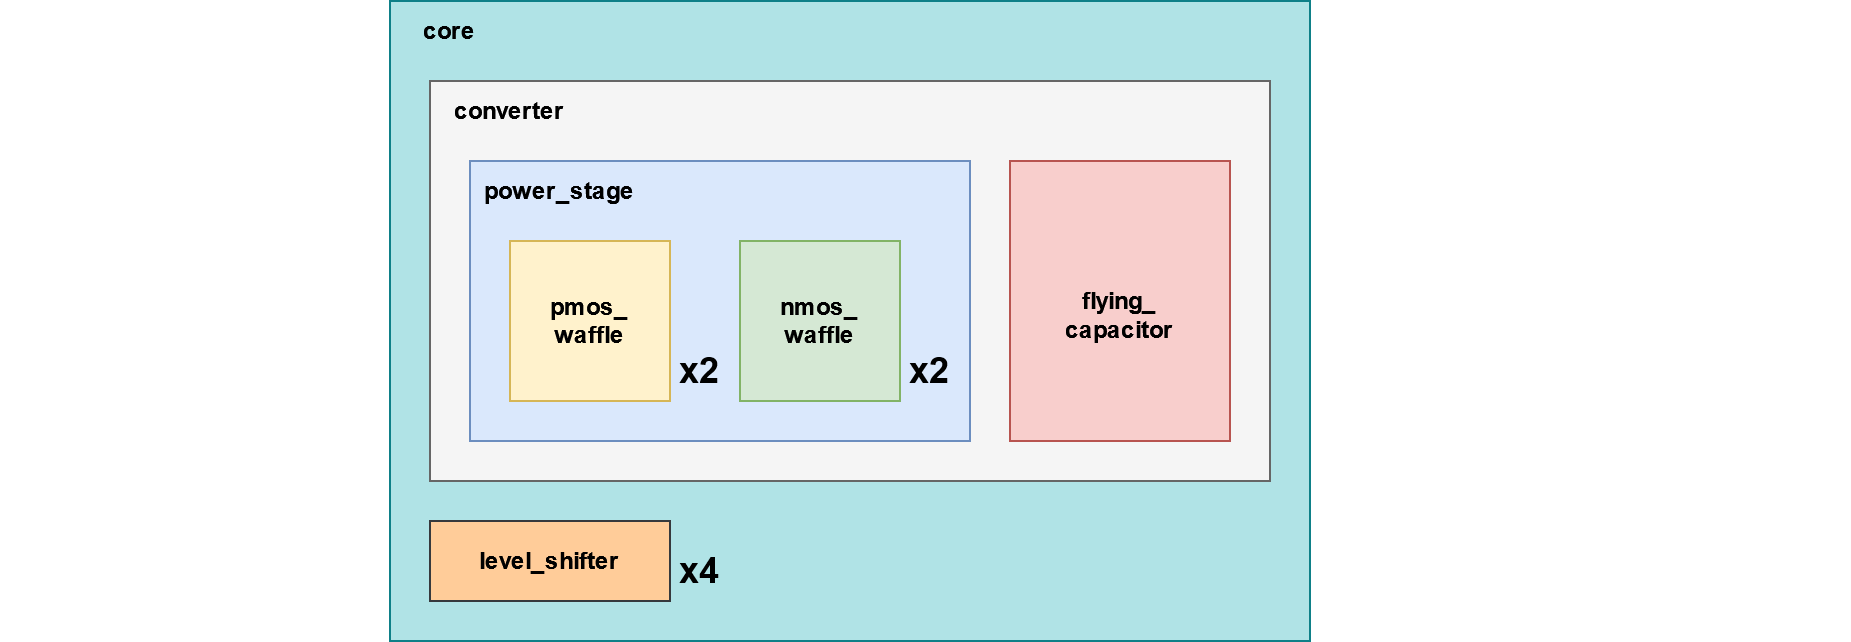

### Custom size Flying Capacitor

It is not recommended to make capacitors bigger than 30um because the size of the metal grains is around 30um, and metals wider than that have lower conductivity. Then, a 30um 'unitary' capacitor is the building block for the flying_cap. The size of the matrix of capacitors depends on the required capacitance. Both MIM capacitor layers available in the sky130 process are used.
The following python code writtes a tcl script that will make a matrix of unitary capacitors, with a certain number of rows (columns number is fixed to better fit the interface of the power_stage).

In [ ]:
# Configurable Parameter
rows = 53 #Number of rows
#Estimated capacitance is:

In [ ]:
# Making of the tcl file
fileName = input(".mag file name: ")
f = open("cap_matrix.tcl","w")
f.write("# #####################\t#\n#\tAC3E - UTFSM\t\t#\n#\tProject: 3LFCC\t\t#\n#\tCap matrix layout\t#\n# #####################\t#\n\n")
f.write("getcell unit_cap.mag\n")
f.write("set boxS [box size]\nset boxV [box values]\n")
f.write("undo\n")
for column in range(0,43):
    for cap in range(0,rows):
        f.write("select clear\n")
        f.write("move to [expr {[lindex $boxV 0]+[lindex $boxS 0]*"+str(column)+"}]i [expr {[lindex $boxV 1]+[lindex $boxS 1]*"+str(cap)+"}]i\n")
        f.write("getcell unit_cap.mag\n")
            
f.write("save\n")
f.close()

Then run the generated tcl in magic

In [ ]:
!VAR=rows magic -dnull -noconsole
!source cap_matrix.tcl
!exit

Finally, metal terminals are added and the flying_capacitor is finished.

In [ ]:
!magic -dnull -noconsole flying_cap.tcl
!exit

### Convert Core
...

In [ ]:
!magic -dnull -noconsole core.tcl
!exit

A .gds file has been generated for the topmodule, along with a netlist (.spice) extracted from the layout.

## Layout v/s Schematic